In [1]:
import torch

from botorch.utils.multi_objective import is_non_dominated

import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams[
    "text.latex.preamble"
] = r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{color}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
torch.manual_seed(4)

# Define the Pareto fronts.
nadir = 0.0 * torch.ones(1, 2, **tkwargs)

strict_points = torch.tensor(
    [
        [0.2, 0.9],
        [0.4, 0.7],
        [0.6, 0.6],
        [0.7, 0.4],
        [0.95, 0.2],
    ],
    **tkwargs
)

weak_points = torch.tensor(
    [
        [0.05, 0.9],
        [0.14, 0.9],
        [0.2, 0.77],
        [0.32, 0.7],
        [0.7, 0.25],
        [0.95, 0.08],
    ],
    **tkwargs
)

interpolate_pf = torch.row_stack(
    [
        torch.tensor([-100, strict_points[0, 1]], **tkwargs),
        strict_points,
        torch.tensor([strict_points[-1, 0], -100], **tkwargs),
    ]
)

truncated_interpolate_pf = torch.row_stack(
    [
        torch.tensor([nadir[0, 0], strict_points[0, 1]], **tkwargs),
        strict_points,
        torch.tensor([strict_points[-1, 0], nadir[0, 1]], **tkwargs),
    ]
)

# Rejection sampling.
num_samples = 20

u = torch.zeros(num_samples, 2, **tkwargs)
num_gen = 0
while num_gen < num_samples:
    sample = 1.1 * torch.rand(1, 2, **tkwargs)
    aug_pf = torch.row_stack([strict_points, sample])
    if not is_non_dominated(aug_pf)[-1]:
        u[num_gen, :] = sample
        num_gen += 1

samples = torch.row_stack([u, weak_points, strict_points])
num_weak = len(weak_points) + len(strict_points)
num_strict = len(strict_points)

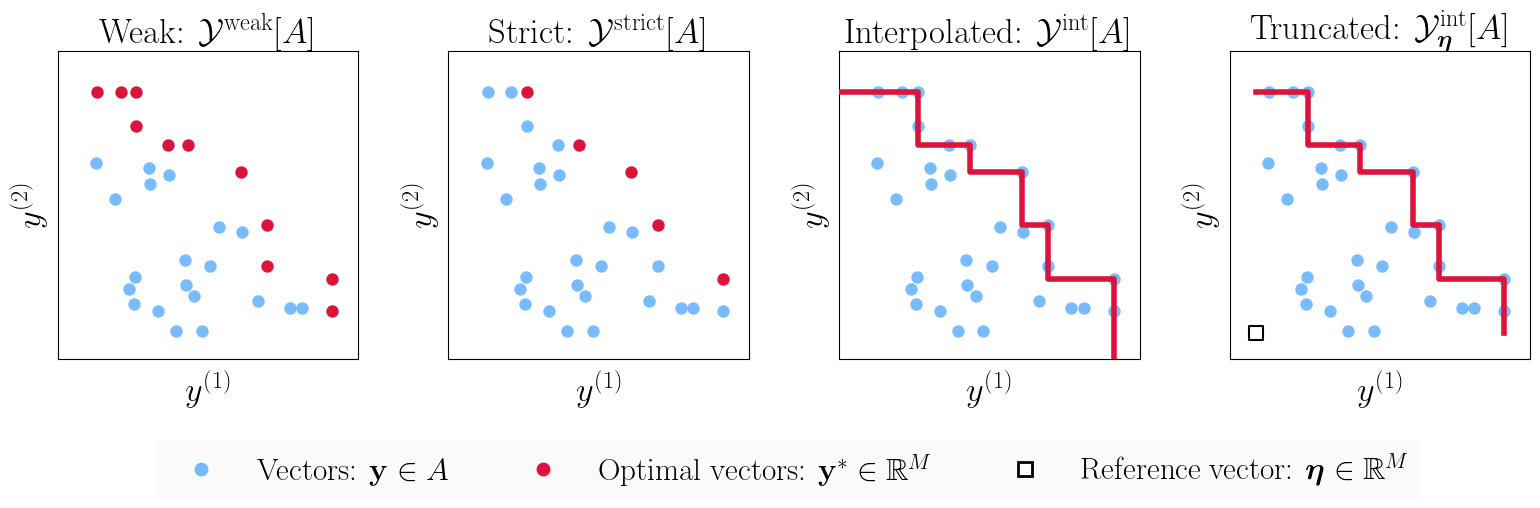

In [3]:
fig, axes = plt.subplots(1, 4, figsize=(19, 4))
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4
)

titles = [
    r"Weak: $\mathcal{Y}^{\text{weak}}[A]$",
    r"Strict: $\mathcal{Y}^{\text{strict}}[A]$",
    r"Interpolated: $\mathcal{Y}^{\text{int}}[A]$",
    r"Truncated: $\mathcal{Y}_{\boldsymbol{\eta}}^{\text{int}}[A]$",
]

for i in range(4):
    ax = plt.subplot(1, 4, i + 1)

    ax.set_xlim([-0.1, 1.05])
    ax.set_ylim([-0.1, 1.05])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(r"$y^{(1)}$", fontsize=25)
    ax.set_ylabel(r"$y^{(2)}$", fontsize=25)
    ax.set_title(titles[i], fontsize=25)
#######################################################################################
# Weak Pareto front.
ax = plt.subplot(1, 4, 1)
ax.scatter(
    samples[:-num_weak:, 0],
    samples[:-num_weak:, 1],
    color="dodgerblue",
    s=80,
    alpha=0.6,
    linewidth=0,
)
ax.scatter(
    samples[-num_weak:, 0],
    samples[-num_weak:, 1],
    color="crimson",
    s=80,
    alpha=1,
    linewidth=0,
)
#######################################################################################
# Strict Pareto front.
ax = plt.subplot(1, 4, 2)
ax.scatter(
    samples[:-num_strict:, 0],
    samples[:-num_strict:, 1],
    color="dodgerblue",
    s=80,
    alpha=0.6,
    linewidth=0,
)
ax.scatter(
    samples[-num_strict:, 0],
    samples[-num_strict:, 1],
    color="crimson",
    s=80,
    alpha=1,
    linewidth=0,
)
#######################################################################################
# Interpolated Pareto front.
ax = plt.subplot(1, 4, 3)
ax.scatter(
    samples[:, 0],
    samples[::, 1],
    color="dodgerblue",
    s=80,
    alpha=0.6,
    linewidth=0,
)
ax.step(
    interpolate_pf[:, 0],
    interpolate_pf[:, 1],
    color="crimson",
    linestyle="-",
    alpha=1,
    linewidth=4,
    zorder=4,
)
#######################################################################################
# Truncated interpolated Pareto front.
ax = plt.subplot(1, 4, 4)
ax.scatter(
    samples[:, 0], samples[::, 1], color="dodgerblue", s=80, alpha=0.6, linewidth=0
)
ax.step(
    truncated_interpolate_pf[:, 0],
    truncated_interpolate_pf[:, 1],
    color="crimson",
    linestyle="-",
    alpha=1,
    linewidth=4,
    zorder=4,
)
ax.scatter(
    nadir[:, 0],
    nadir[:, 1],
    color="w",
    marker="s",
    linestyle="None",
    s=100,
    edgecolors="k",
    linewidth=1.5,
    zorder=5,
)
#######################################################################################
# Legend.
white_square = mlines.Line2D(
    [],
    [],
    color="w",
    marker="s",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=2,
)

blue_dot = mlines.Line2D(
    [],
    [],
    color="dodgerblue",
    marker=".",
    linestyle="None",
    markeredgecolor="None",
    alpha=0.6,
    markersize=20,
)
red_dot = mlines.Line2D(
    [],
    [],
    color="crimson",
    marker=".",
    linestyle="None",
    markeredgecolor="None",
    markersize=20,
)

labels = [
    r"Vectors: $\mathbf{y} \in A$",
    r"Optimal vectors: $\mathbf{y}^* \in \mathbb{R}^M$",
    r"Reference vector: $\boldsymbol{\eta} \in \mathbb{R}^M$",
]
handles = [blue_dot, red_dot, white_square]
axes[0].legend(
    labels=labels,
    handles=handles,
    loc=(0.33, -0.45),
    ncol=3,
    fontsize=22.5,
    facecolor="k",
    framealpha=0.02,
)

plt.show()